In [1]:
# %%
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

In [2]:
# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')
parser.add_argument('-f')


args = parser.parse_args()

torch.manual_seed(args.seed)

In [3]:
# %%
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset, batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size, shuffle=True)

In [4]:
# %%
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

In [5]:
# %%
import matplotlib.pyplot as plt

import seaborn as sns


def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')

In [6]:
import torch
from torch import nn
import torch.optim as optim

In [7]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6272, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [8]:
num_epochs = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [9]:
model = CNN()
print(model)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
print(model.parameters())

print(len(list(model.parameters())))

# Convolution 1: 16 Kernels
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 16 Kernels
print(list(model.parameters())[1].size())

# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16
print(list(model.parameters())[3].size())

# Fully Connected Layer 1
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x12b4d4eb0>
8
torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 6272])
torch.Size([64])


In [11]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(imbalanced_step_train_loader):
        images = images.requires_grad_()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images = images.requires_grad_()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            print('Iteration: {}. Accuracy: {}'.format(iter, accuracy))

Iteration: 500. Accuracy: 84
Iteration: 1000. Accuracy: 89
Iteration: 1500. Accuracy: 92


In [15]:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

from sklearn.metrics import roc_auc_score

model.eval()
correct_vals = []
auroc_scores = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_vals.append((predicted == labels).sum().item())
        accuracy = (correct / total) * 100
        
        sm = nn.Softmax(dim = 1)
        prob = sm(outputs)
        preds = np.argmax(prob, axis = 1)
        arc = roc_auc_score(labels, prob, multi_class = 'ovr', average = 'macro')
        auroc_scores.append(arc)

    print('Accuracy on 1000 Images: {}'.format(accuracy))

Accuracy on 1000 Images: 96.98


In [13]:
for i in range(len(correct_vals)):
    correct_vals[i] = correct_vals[i] * .10

In [14]:
#from joblib import dump, load

#dump(model, 'CNN_step.joblib')

['CNN_step.joblib']

In [16]:
avg_auroc = sum(auroc_scores) / len(auroc_scores)
print('Average AUROC: {}'.format(avg_auroc))

Average AUROC: 0.9993784229061411


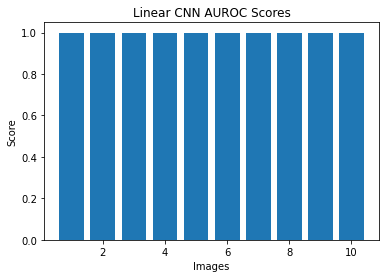

In [18]:
x_axis = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.bar(x_axis, avg_auroc)
plt.title('Linear CNN AUROC Scores')
plt.xlabel('Images')
plt.ylabel('Score')
plt.savefig('auroc_step_cnn.png')
plt.show()

In [ ]:
#print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
plt.show()

In [ ]:
#print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
plt.show()

In [ ]:
# %%
for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break
    
for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break